# Results

In [1]:
require('cowplot')
library('ggplot2')
source('get_expected_pval_and_equiv_z.R')
source('multiplot.R')
source('plot_lib.R')
theme_set(theme_gray()) # switch to default ggplot2 theme for good

Loading required package: cowplot
Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



#### Load data from the CSV files

##### One-sample

In [2]:
allsimudat_btw0 <- load_data_from_csv('^test1_.*btw0_.*')
allsimudat_btw1 <- load_data_from_csv('^test1_.*btw1_.*')
allsimudat <- rbind(allsimudat_btw0, allsimudat_btw1)

##### Two-sample

In [4]:
allsimudat2_btw0 <- load_data_from_csv('^test2_.*btw0_.*')
allsimudat2_btw1 <- load_data_from_csv('^test2_.*btw1_.*')
allsimudat2 <- rbind(allsimudat2_btw0, allsimudat2_btw1)

In [5]:
unique(allsimudat2_btw0$glm)

[1] 2

##### Unbalanced two-sample

In [25]:
allsimudat3_btw0 <- load_data_from_csv('^test3_.*btw0_.*')
allsimudat3_btw1 <- load_data_from_csv('^test3_.*btw1_.*')
allsimudat3 <- rbind(allsimudat3_btw0, allsimudat3_btw1)

[1] "pattern= test3_btw0_"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/Scripts/simulations/lib/../../../data/allsimudat_test3_btw0_.csv  not found, reprocessing the data."
[1] "^test3_.*btw0_.*"
[1] "90 simulations"
[1] "Reading  90  /  90"
[1] "with 400"
[1] "/Volumes/camille/IBMA_simu//test3_k50_btw0_wth80_nominal/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/Scripts/simulations/lib/../../../data/allsimudat_test3_btw0_.csv"
[1] "Reading  89  /  90"
[1] "with 400"
[1] "/Volumes/camille/IBMA_simu//test3_k50_btw0_wth80_datascl_soft50_100/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/Scripts/simulations/lib/../../../data/allsimudat_test3_btw0_.csv"
[1] "Reading  88  /  90"
[1] "with 400"
[1] "/Volumes/camille/IBMA_simu//test3_k50_btw0_wth80_datascl_soft50_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/Scripts/simulations/lib/../../../data/allsimudat_test3_btw0_.csv"
[1] "Reading

### 1. Robustness to units mismatch

We look how contrast-based methods are affected by the units issue.

In [26]:
con_methods <- c("megaMFX","megaRFX","permutCon", "megaFFX_FSL")
con_data_1 <- subset(allsimudat, is.finite(expectedz) & expectedz>0  &  methods %in% con_methods)
con_data_2 <- subset(allsimudat2, is.finite(expectedz) & expectedz>0 & methods %in% con_methods)
con_data_3 <- subset(allsimudat3, is.finite(expectedz) & expectedz>0 & methods %in% con_methods)

##### Plots

###### Units mismtach

We look at the best case scenario for each contrast-based method:
 - MFX GLM: τ2 ≠ 0 -> τ2 = 1
 - RFX GLM: σ2<<τ2 or σ2/n constant for all studies -> σ2=1/2
 - Contrast Permutation: anything
 - FFX GLM: τ2 = 0

In [8]:
best_con_data_1 <- subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==25)
best_con_data_2 <- subset(con_data_2, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==50)
best_con_data_3 <- subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==50)

#### One-sample tests

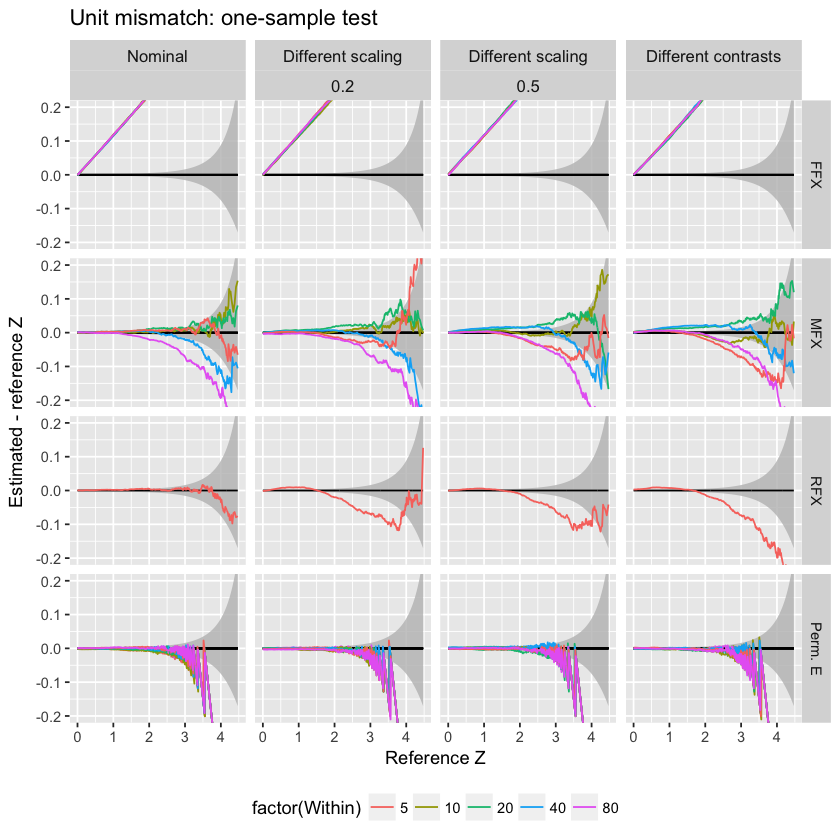

In [9]:
source('plot_lib.R')
source('prepare_data.R')
source('plot_unit_mismatch.R')
source('plot_blandaldman_z.R')
# Note for RFX we only keep btw=1 for display purposes (results with btw=0 are very similar)
# Also we only keep z>4.5 (to avoid very variable tail affecting ylim)
plot_unit_mismatch(
    subset(best_con_data_1, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))), 
    'one-sample test', mult=FALSE, single=TRUE, lim=0.2, 
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test1"), max_z=4.5)

#### Two-sample tests

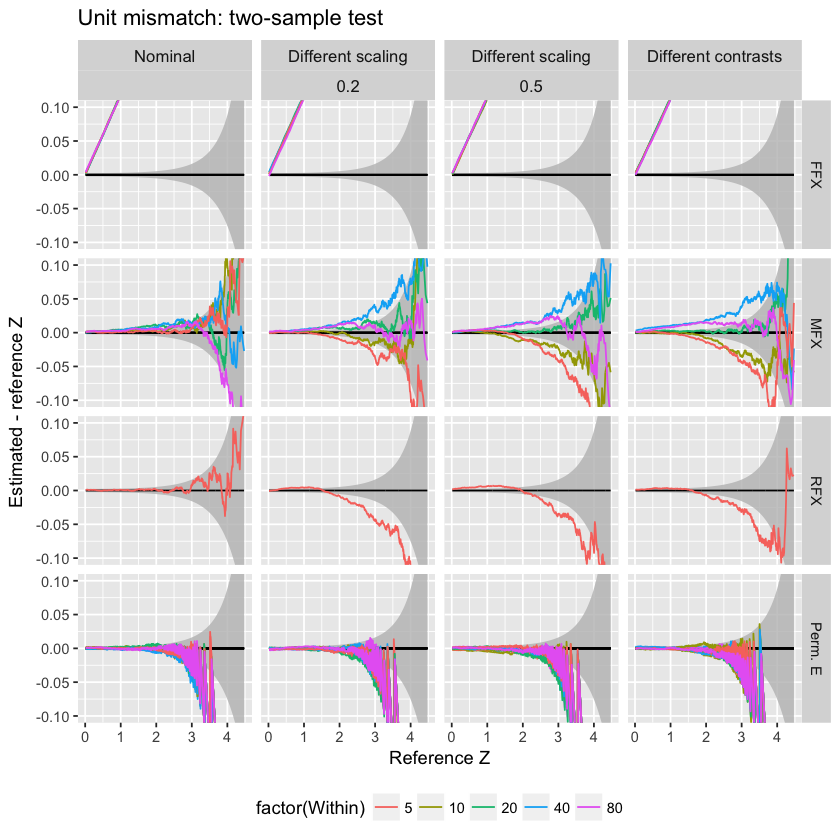

In [10]:
source('plot_lib.R')
source('plot_unit_mismatch.R')
source('plot_blandaldman_z.R')
plot_unit_mismatch(
    subset(best_con_data_2, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    'two-sample test', mult=FALSE, single=TRUE, lim=0.1, 
     filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test2"), max_z=4.5)

#### Unbalanced two-sample tests)

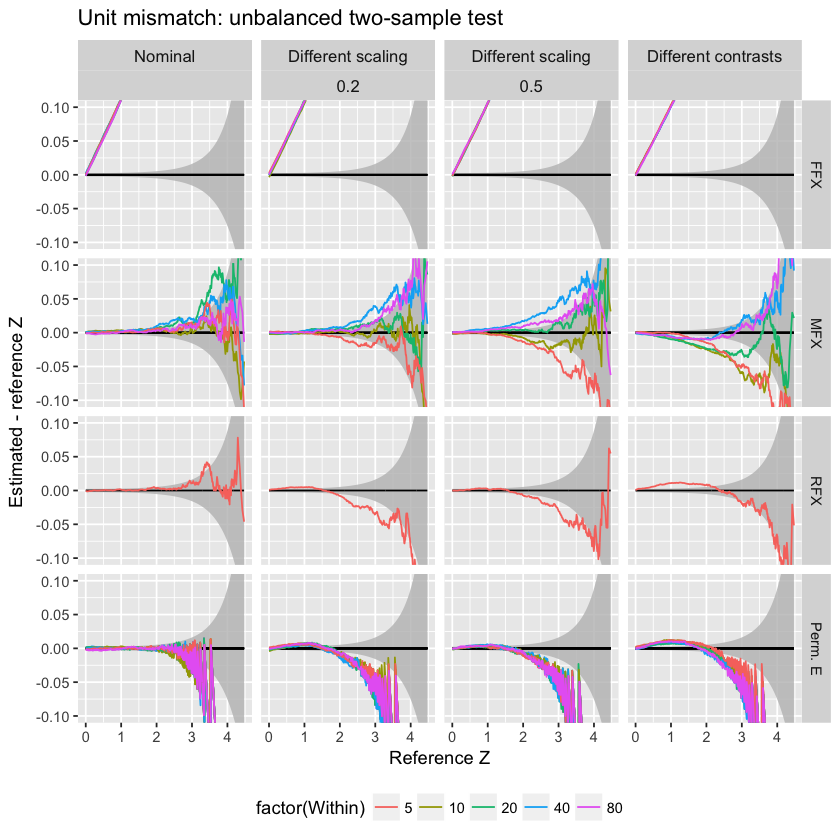

In [11]:
plot_unit_mismatch(
    subset(best_con_data_3,((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    'unbalanced two-sample test', mult=FALSE, single=TRUE, lim=0.1,
     filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test3"), max_z=4.5)

### 2. Robustness to small sample sizes

In [12]:
con_data_1_small_sample <- subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & unitMism=="nominal")
con_data_2_small_sample <- subset(con_data_2, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & unitMism=="nominal")
con_data_3_small_sample <- subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & unitMism=="nominal")

Warning message:
“Removed 2270 rows containing missing values (geom_path).”Warning message:
“Removed 950 rows containing missing values (geom_path).”Warning message:
“Removed 950 rows containing missing values (geom_path).”Warning message:
“Removed 2270 rows containing missing values (geom_path).”

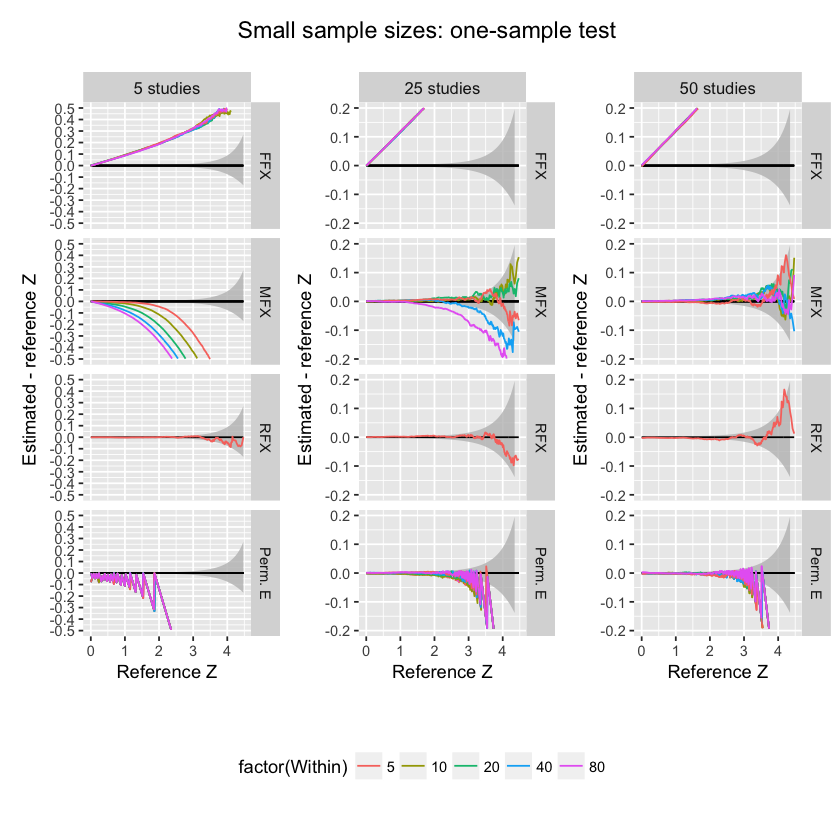

In [13]:
source('plot_lib.R')
source('plot_sample_sizes.R')
source('plot_blandaldman_z.R')
plot_sample_sizes(
    subset(con_data_1_small_sample, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    title='one-sample test', lim=c(0.5, 0.2, 0.2),
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "samplesizes_test1"), 
    max_z=4.5)

Warning message:
“Removed 3940 rows containing missing values (geom_path).”Warning message:
“Removed 2660 rows containing missing values (geom_path).”Warning message:
“Removed 2660 rows containing missing values (geom_path).”Warning message:
“Removed 3940 rows containing missing values (geom_path).”

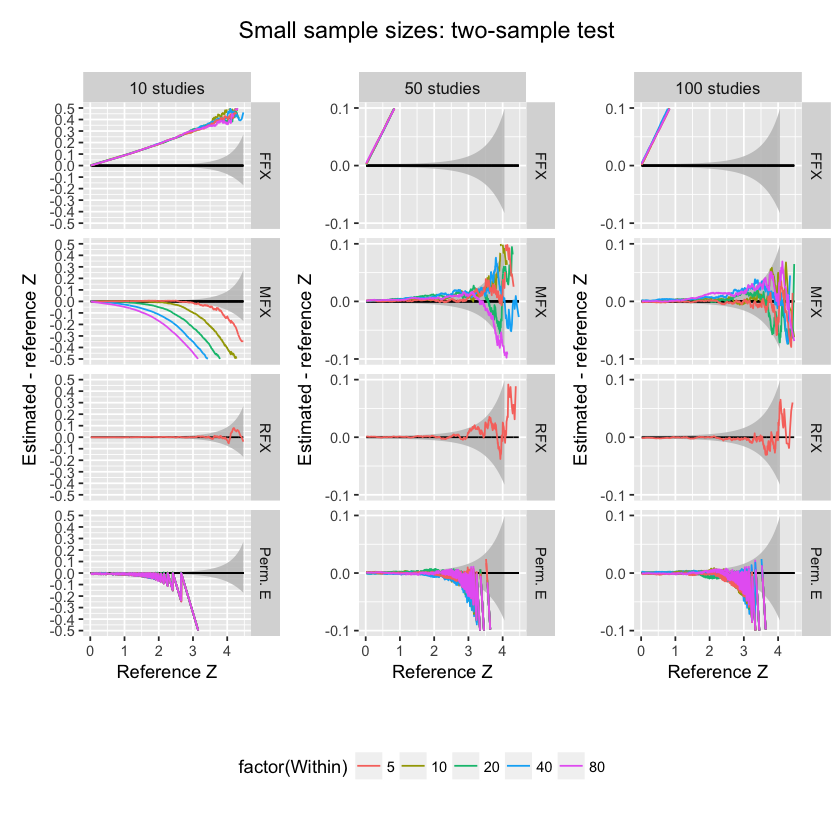

In [14]:
plot_sample_sizes(
    subset(con_data_2_small_sample, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    title='two-sample test', lim=c(0.5, 0.1, 0.1),
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "samplesizes_test2"), 
    max_z=4.5)

In [15]:
max(con_data_2_small_sample[con_data_2_small_sample$nStudies==100,]$expectedz)

[1] 4.758609

Warning message:
“Removed 2150 rows containing missing values (geom_path).”Warning message:
“Removed 1060 rows containing missing values (geom_path).”Warning message:
“Removed 1060 rows containing missing values (geom_path).”Warning message:
“Removed 2150 rows containing missing values (geom_path).”

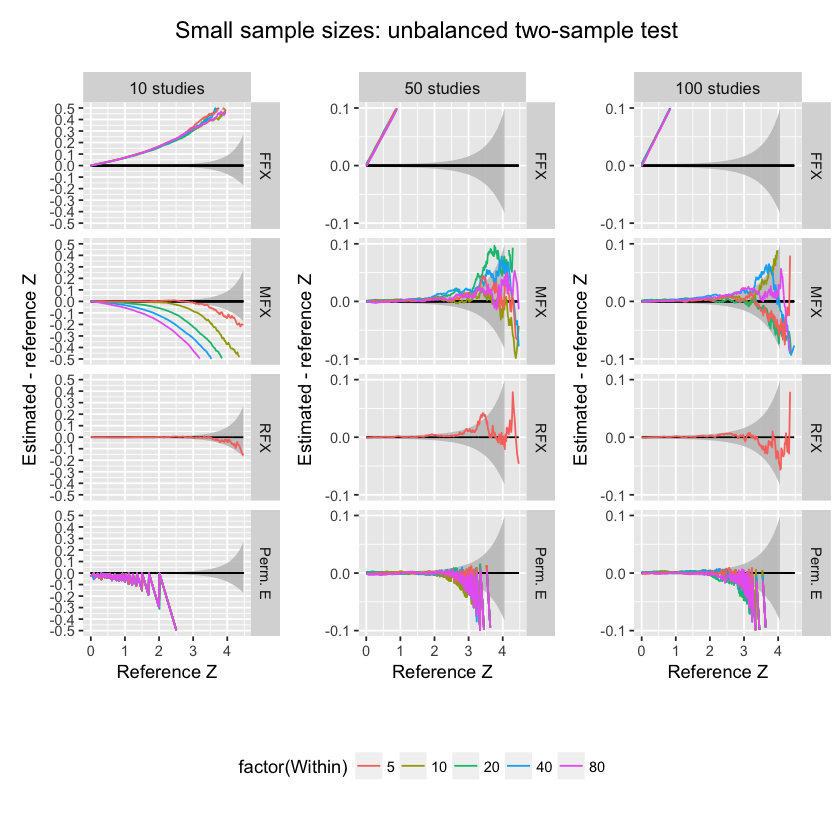

In [16]:
plot_sample_sizes(
    subset(con_data_3_small_sample, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    title='unbalanced two-sample test', lim=c(0.5, 0.1, 0.1),
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "samplesizes_test3"), max_z=4.5)

### 2. Robustness to violation of underlying assumptions or ...

#### GLM MFX

In [17]:
con_data_MFX_not_assump <- rbind(subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between!=1)
    ) & unitMism=="nominal"),subset(con_data_2, 
    ((methods %in% c("megaMFX") & Between!=1)
    ) & unitMism=="nominal"),subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between!=1)
    ) & unitMism=="nominal"))

con_data_MFX_not_assump$nStudiesPerGroup <- con_data_MFX_not_assump$nStudies
con_data_MFX_not_assump$nStudiesPerGroup[con_data_MFX_not_assump$glm>1] <- con_data_MFX_not_assump[con_data_MFX_not_assump$glm>1,]$nStudiesPerGroup/2

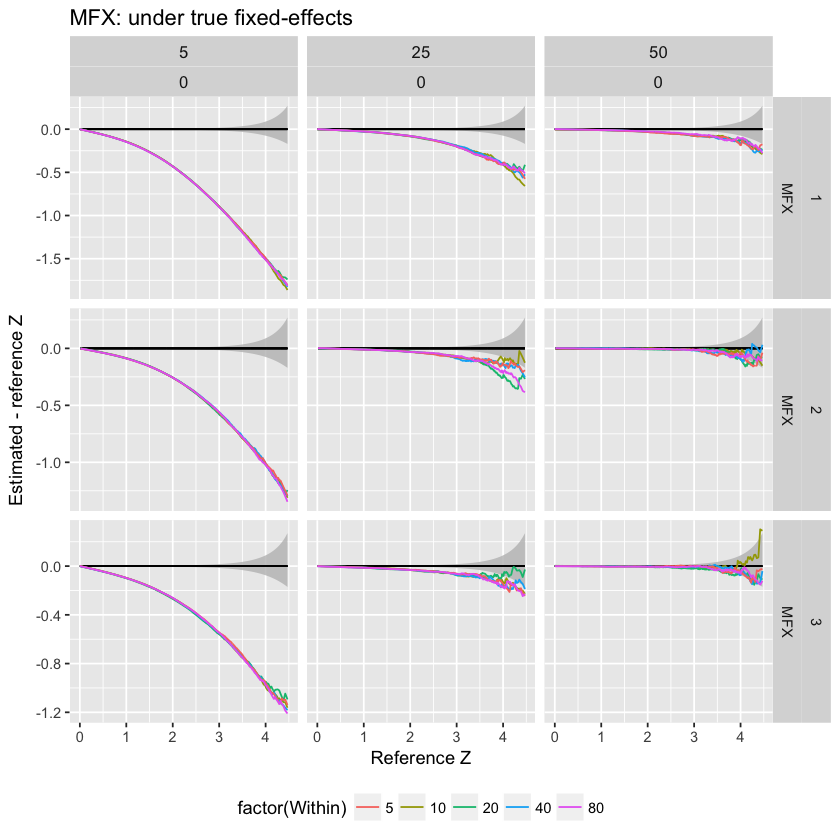

In [18]:
source('plot_blandaldman_z.R')
p <- plot_blandaldman_z(
    list(con_data_MFX_not_assump), 
    glm+methods~nStudiesPerGroup+Between, 
    "MFX: under true fixed-effects", FALSE, NA, NA, max_z=4.5)

# plot_sample_sizes(
#     subset(con_data_MFX_assump, 
#            expectedz<4),
#     title='MFX: underlying assumptions', lim=1.5)

In [19]:
con_data_MFX_assump <- rbind(subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between==1)
    ) & unitMism=="nominal"),subset(con_data_2, 
    ((methods %in% c("megaMFX") & Between==1)
    ) & unitMism=="nominal"),subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between==1)
    ) & unitMism=="nominal"))

con_data_MFX_assump$nStudiesPerGroup <- con_data_MFX_assump$nStudies
con_data_MFX_assump$nStudiesPerGroup[con_data_MFX_assump$glm>1] <- con_data_MFX_assump[con_data_MFX_assump$glm>1,]$nStudiesPerGroup/2

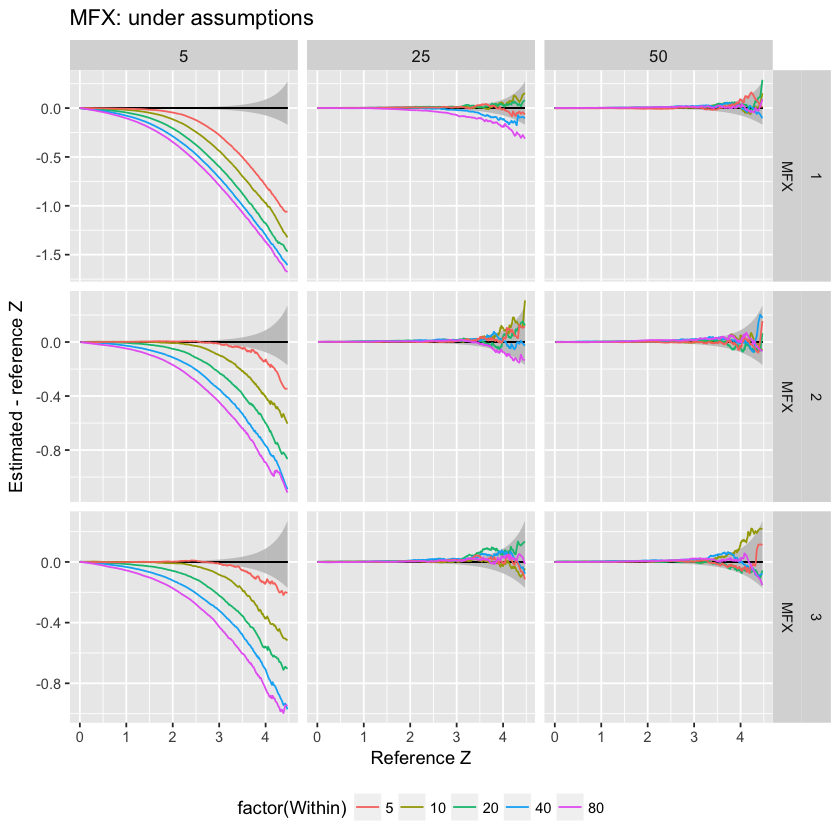

In [20]:
p <- plot_blandaldman_z(
    list(con_data_MFX_assump), 
    glm+methods~nStudiesPerGroup, 
    "MFX: under assumptions", FALSE, NA, NA, max_z=4.5)

In [21]:
# con_data_1_small_sample <- subset(con_data_1, 
#     ((methods %in% c("megaMFX") & Between==1) | 
#      (methods %in% c("megaRFX") & Within==5)  | 
#      (methods %in% c("megaFFX_FSL") & Between==0) |
#      (methods %in% c("permutCon"))
#     ) & unitMism=="nominal")
con_data_1_MFX_assump <- subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between!=1)
    ) & unitMism=="nominal")

In [27]:
con_data_RFX_not_assump <- rbind(subset(con_data_1, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"),subset(con_data_2, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"),subset(con_data_3, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"))

con_data_RFX_not_assump$nStudiesPerGroup <- con_data_RFX_not_assump$nStudies
con_data_RFX_not_assump$nStudiesPerGroup[con_data_RFX_not_assump$glm>1] <- con_data_RFX_not_assump[con_data_RFX_not_assump$glm>1,]$nStudiesPerGroup/2

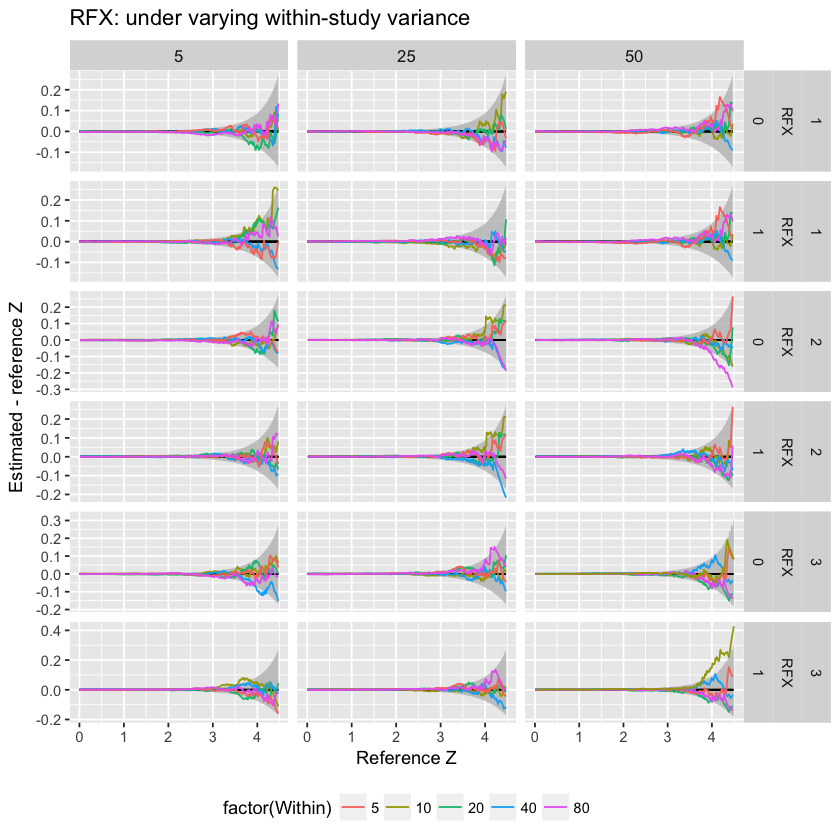

In [28]:
p <- plot_blandaldman_z(
    list(con_data_RFX_not_assump),
    glm+methods+Between~nStudiesPerGroup, 
    "RFX: under varying within-study variance", 
    FALSE, lim=NA, max_z=4.5,
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "rfx_assump"))

In [24]:
num_simu = 30*30*30*38
print(num_simu)
min_p = 1/num_simu
print(min_p)
-qnorm(min_p)
max(con_data_1$expectedz)

[1] 1026000
[1] 9.746589e-07


[1] 4.758609

[1] 4.758609